# Feature Selection and Regularization Exercise

In this exercise I explore the relationships between the physical characteristics and specific skills of soccer players on their overall performance using a sample data set. I use cross-validation in order to implement a backwards search for important features and explore regularization in both Lasso and Ridge Regression schemes.

In [3]:
#start by importing important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, make_scorer

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [4]:
#clean the data
#drop irrelevant variables and dummy code ones for which that would be appropriate
df=pd.read_csv("footballer_small.csv")
# print(df.shape)
toBeDropped=['ID','club', 'club_logo','flag','nationality','photo','potential','birth_date']
df=df.drop(toBeDropped, axis="columns")
# print(df.shape)
toBeDummied=['work_rate_att','work_rate_def','preferred_foot']
df=pd.get_dummies(df,columns=toBeDummied, drop_first=False)

X=df.drop('overall', axis='columns')
y=df.overall

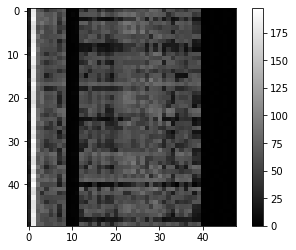

,age,height_cm,weight_kg,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_High,work_rate_att_Low,work_rate_att_Medium,work_rate_def_High,work_rate_def_Low,work_rate_def_Medium,preferred_foot_Left,preferred_foot_Right
2858,20,178.0,69.0,61,38,52,54,62,71,1,2,2,46,29,61,61,31,53,35,33,48,51,63,59,56,62,66,59,81,77,70,34,64,62,47,52,41,59,62,62,0,0,1,0,0,1,0,1
723,21,182.0,77.0,80,66,64,76,49,64,1,4,2,63,64,66,66,55,77,60,54,65,77,83,78,84,67,62,75,69,73,70,66,34,52,67,65,67,66,43,48,0,0,1,0,0,1,1,0
1953,25,187.0,76.0,73,78,65,77,43,73,1,1,2,12,12,18,34,14,11,9,12,35,23,44,42,43,77,57,25,70,35,55,19,41,13,18,45,27,52,14,15,0,0,1,0,0,1,0,1
1981,21,175.0,77.0,89,72,66,78,33,63,1,3,4,73,74,49,69,65,80,57,55,55,75,90,89,78,67,78,74,55,66,64,71,59,24,72,68,62,68,35,33,0,0,1,0,0,1,0,1
137,19,168.0,59.0,69,53,59,68,44,48,1,2,4,42,50,49,67,51,66,59,52,60,67,77,63,81,54,76,60,57,50,43,54,55,49,47,65,57,60,42,40,1,0,0,1,0,0,0,1
1825,24,174.0,64.0,84,55,55,70,36,62,1,3,4,57,55,42,55,55,67,69,53,50,68,85,83,91,60,89,53,75,69,60,57,54,26,59,53,55,56,39,37,1,0,0,0,1,0,0,1
1313,26,182.0,84.0,60,55,59,59,63,73,1,3,3,54,51,67,65,40,60,34,48,62,62,62,59,51,56,56,61,32,71,80,62,66,63,52,59,55,55,64,62,0,0,1,0,0,1,0,1
1455,21,178.0,70.0,73,61,50,62,25,51,1,3,3,52,71,61,56,58,62,33,28,38,61,75,72,61,55,68,51,66,61,51,48,35,20,62,57,65,57,19,24,0,0,1,0,0,1,0,1
672,23,187.0,75.0,63,61,57,63,40,61,1,1,3,14,16,16,27,12,11,12,19,23,23,40,40,39,60,53,18,53,21,61,19,20,21,20,37,18,55,16,17,0,0,1,0,0,1,0,1
1724,30,189.0,87.0,59,56,55,57,41,58,1,1,2,15,17,13,37,17,18,13,18,27,23,39,42,56,48,46,22,58,29,59,15,40,23,20,43,13,33,9,9,0,0,1,0,0,1,0,1


In [5]:
#split the data into testing and training sets
#split up the data
Xtrain, Xtest, ytrain, ytest= train_test_split(X, y, test_size=500, random_state=0)

#visualize the first 50 observations as an image and as a dataframe
first50=Xtrain.head(50)
plt.imshow(first50, cmap='gray')
plt.colorbar()
plt.show()

display(Xtrain.head(50))

In [6]:
#build a pipeline that will standardize all features in the training set and then fit a linear regression model to it
model1=Pipeline([('scaler',sk.preprocessing.StandardScaler(with_mean=True, with_std=True)),
               ('linear_regression', sk.linear_model.LinearRegression(fit_intercept=False))])

In [7]:
#create a main design matrix with second order interaction terms
poly = sk.preprocessing.PolynomialFeatures(2, include_bias=False)
X1 = poly.fit_transform(Xtrain) 

In [8]:
#create three other different design matrices in order to explore the effects of features

idx=[] # this list will hold the indices of the columns we are wanting to remove
idx.append(X.columns.get_loc("standing_tackle"))
idx.append(X.columns.get_loc("composure"))
idx.append(X.columns.get_loc("marking"))

X2=pd.DataFrame(Xtrain).drop(Xtrain.columns[idx[0]], axis=1) # drop standing tackle
X2=poly.fit_transform(X2)

X3=pd.DataFrame(Xtrain).drop(Xtrain.columns[idx[1]], axis=1) # drop composure
X3=poly.fit_transform(X3)

X4=pd.DataFrame(Xtrain).drop(Xtrain.columns[idx[2]], axis=1) # drop marking
X4=poly.fit_transform(X4)

In [9]:
#apply the standardizer pipeline an evaluate each of the models on each design matrix as a first step in a backwards search
#define the partitions
kf=KFold(n_splits=10,shuffle=False)
sc=make_scorer(mean_squared_error)

#now perform cross-validation on each of the models
# print(ytrain.size)
# print(X4.shape)
cv_scores=[]
cv_scores.append((cross_val_score(model1,X1,ytrain,cv=kf,scoring=sc)).mean())
cv_scores.append((cross_val_score(model1,X2,ytrain,cv=kf,scoring=sc)).mean())
cv_scores.append((cross_val_score(model1,X3,ytrain,cv=kf,scoring=sc)).mean())
cv_scores.append((cross_val_score(model1,X4,ytrain,cv=kf,scoring=sc)).mean())

print(cv_scores)

[4375.197475453102, 4374.291471970917, 4380.138096034914, 4371.055499530745]


Observation: the model with the "marking" column dropped has the lowest cross-validation score and as such would drop this feature in the first step of a backwards search.

In [11]:
#now lets explore ridge and lasso regression
#start with ridge regression, and use cross-validation to tune the regularization parameter 
import math
lam=np.linspace(math.exp(-8), math.exp(6), 15)
cv_scores=[] ##these are the prediction errors
training_errors=[]  ##these are the training errors
for i in lam:
    model3=Pipeline([('scaler',sk.preprocessing.StandardScaler(with_mean=True, with_std=True)),
                ('ridge',sk.linear_model.Ridge(alpha=i,fit_intercept=True))]) #define a new pipeline each time
    model3.fit(X1,ytrain)
    ytrain_pred=model3.predict(X1)
    training_errors.append(np.mean(np.square(np.subtract(ytrain_pred, ytrain))))
    cv_scores.append(np.mean(cross_val_score(model3,X1,ytrain, cv=10, scoring=sc)))



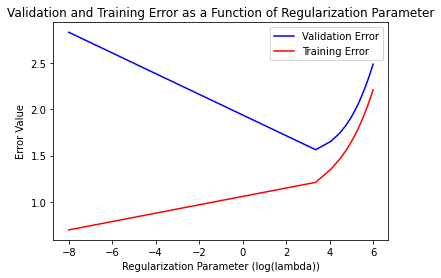

The regularization parameter corresponding to the lowest validation error is: 28.816653893349844


In [12]:
#now plot the training and prediciton errors as functions of lam
plt.plot(np.log(lam), cv_scores, color='blue', label="Validation Error")
plt.plot(np.log(lam), training_errors, color='red', label="Training Error")
plt.title("Validation and Training Error as a Function of Regularization Parameter")
plt.xlabel("Regularization Parameter (log(lambda))")
plt.ylabel("Error Value")
plt.legend()
plt.show()

# print(lam)

#find out which regularization parameter minimizes the validation error
minValErr=cv_scores[0] #start at zero and see which one is the lowest
idx=0
for i in range(0,len(lam)):
    if cv_scores[i]<minValErr:
        idx=i#save the index of the lambda value which gave the lower validation error
        minValErr=cv_scores[i]
print("The regularization parameter corresponding to the lowest validation error is:", lam[idx])

The best regularization parameter is the one for which the validation error is the lowest, which corresponds to a value of approximately lambda=28.82. As lambda approaches zero (or decreases), the model complexity increases, which results in an increase in validation error and a decrease in training error. Training and validation error are negatively correlated, as model complexity increases, the model is less biased. However, in the context of the bias-variance tradeoff, this also means that model variance has increases for a given data point, which results in a larger validation error. Both the training and validation error increase as lambda approaches infinity because here we are approaching the simplest version of the model, one which does not sufficiently model the data. Here, there is high bias, but low variance, so the model is "under-fit", resulting in both high training and validation error.

In [13]:
#now fit the model using the optimal regression parameter value
#we will use the lambda value for which the cross-validation error (mse) was lowest
# print(min(cv_scores))
lam_value=lam[np.where(cv_scores==min(cv_scores))]
# alpha=log(lam_value)

#fit the model and make predictions
ridge=sk.linear_model.Ridge(alpha=math.log(lam_value),fit_intercept=True).fit(Xtrain,ytrain)
ypred=ridge.predict(Xtest)

#compute the mean squared error on the test data as well as the 95% confidence interval
mse_test=np.mean(np.square(np.subtract(ytest,ypred)))
from scipy.stats import t
n=len(ypred)
t_val=t.ppf(1-0.05/2,df=n-1)# compute the t statistic
stdErr=ypred.std(ddof=1)/np.sqrt(n) #compute the standard error
upper=mse_test+t_val*stdErr
lower=mse_test-t_val*stdErr
bounds=np.array([lower, upper])

print("The mean squared error on the test data is ", mse_test, " and the 95% confidence interval is given by ", bounds, ".")

The mean squared error on the test data is  6.452524930628159  and the 95% confidence interval is given by  [5.85352423 7.05152563] .


ERROR! Session/line number was not unique in database. History logging moved to new session 832


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass eps=0.005 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


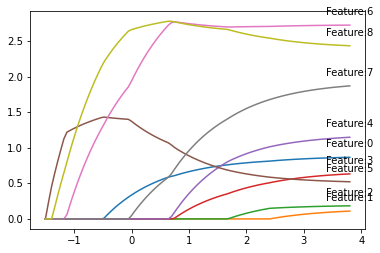

In [14]:
#now moving onto lasso regression
#lets simplify the model to the first nine features and visualize each of their importance
# Make a new, reduced design matrix 
X_new=X.drop(X.columns[9:], axis=1)
scaler = sk.preprocessing.StandardScaler(with_mean=True, with_std=True)
X_new_std_scaled = scaler.fit_transform(X_new)

# Create a lasso path 
eps = 5e-3
lambda_lasso, coefs_lasso, _ = sk.linear_model.lasso_path(X_new_std_scaled, y, eps, n_alphas=100, alphas= None, fit_intercept=False)
neg_log_lambda = -np.log(lambda_lasso)

# Plot the lasso path
for i in range(9): # we have 9 features in this model
    l1 = plt.plot(neg_log_lambda, coefs_lasso[i,])
    label = f'Feature:{i}'
    plt.annotate(label, # this is the text
                 (neg_log_lambda[-1],coefs_lasso[i,-1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

The feature that drops out of the lasso path first is the feature at index 1, which is the height. The feature that stays on the path the longest is the feature with index 5, which is passing.

[13.348789211556303, 14.805483822122174, 17.290494075623773, 20.40260753506886, 24.34457214107862, 29.364525542209115, 35.389142045590155, 41.67131794757593, 47.40115968576094, 49.380396008230456, 49.380396008230456, 49.380396008230456, 49.380396008230456, 49.380396008230456, 49.380396008230456]


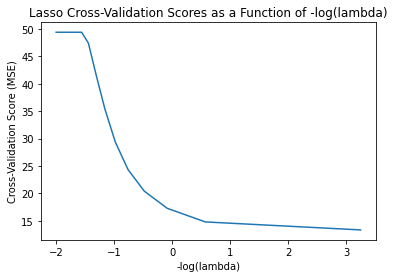

In [15]:
#again, use cross-validation to tune the lasso regression coefficient

lasso_lam=np.linspace(math.exp(-3.25), math.exp(2), 15) #i chose length 15 because it wasnt specified and this was the length used in Q6
neg_log_lam=-1*np.log(lasso_lam)
lasso_cv_scores=[]
for i in lasso_lam:
    model14=sk.linear_model.Lasso(alpha=i)#, data_lasso_ss,y,cv=10,scoring = 'neg_mean_squared_error')
    lasso_cv_scores.append(-1*np.mean(cross_val_score(model14,X_new_std_scaled,y, cv=10, scoring='neg_mean_squared_error')))


print(lasso_cv_scores)
plt.plot(neg_log_lam,lasso_cv_scores)
plt.title("Lasso Cross-Validation Scores as a Function of -log(lambda)")
plt.xlabel("-log(lambda)")
plt.ylabel("Cross-Validation Score (MSE)")
plt.show()